<h1>1. The NBA Career Prediction</h1>

<p>This .ipynb is designed to train a Random Forest model using the provided file 2022_train.csv to predict the probability of an NBA rookie player will last at least 5 years in the league based on its stats. </p> 
<p> In the first assignment my focus was on feature engineering. I used default random forest settings with unconstrained depth and 200 forests . <p>
<p> In this submission, I will be focusing a lot more effort on cleaning the training data prior to applying feature engineering and model selection. <p>
<p> Also, I have added 100 more forests to Random Forest and compare this to XGB in the model selection. <p>


In [2]:
"""
The NBA Career Prediction - assignment 1
Team member: Olivia Dewi, Federico Gonzales, Tim Wang
"""
import csv
import numpy as np
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from IPython.display import display, HTML
from math import log
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import warnings
warnings.filterwarnings("ignore")

The scikit-learn version is 1.1.3.


<h1>2. We are provided with three sets of datasets, namely:</h1>
<p> a) training data <p> b) test data  <p> c) sample submission

<h4> Let's load all of them </h4>

In [3]:
#The training data
trainingdata =  pd.read_csv("../data/raw/2022_train.csv")

In [4]:
#The test data
testdata = pd.read_csv("../data/raw/2022_test.csv")

In [5]:
#The sample submission
sample = pd.read_csv("../data/raw/2022_sample_submission.csv")

<h1>3. Data exploration </h1>

<h2> 3.1 Let's look at what columns we have in the three datasets </h2>

In [6]:
print("Training data columns are: ") 
trainingdata.columns


Training data columns are: 


Index(['Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')

In [7]:
print("Test data columns are: ") 
testdata.columns


Test data columns are: 


Index(['Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'],
      dtype='object')

In [8]:
print("Sample submission columns are: ") 
sample.columns

Sample submission columns are: 


Index(['Id', 'TARGET_5Yrs'], dtype='object')

<h4>Explanations on the data fields:</h4>

<p>Id - Player Identifier</p>
<p>GP - Games Played</p>
<p>MIN - Minutes Played</p>
<p>PTS - Points Per Game</p>
<p>FGM - Field Goals Made</p>
<p>FGA - Field Goals Attempts</p>
<p>FG% - Field Goals Percent</p>
<p>3P Made - 3-Points Made</p>
<p>3PA - 3-Points Attempts</p>
<p>3P% - 3-Points Percent</p>
<p>FTM - Free Throw Made</p>
<p>FTA - Free Throw Attempts</p>
<p>FT% - Free Throw Percent</p>
<p>OREB - Offensive Rebounds</p>
<p>DREB - Defensive Rebounds</p>
<p>REB - Rebounds</p>
<p>AST - Assists</p>
<p>STL - Steals</p>
<p>BLK - Blocks</p>
<p>TOV - Turnovers</p>
<p>TARGET_5Yrs - Outcome: 1 if career length >= 5 years, 0 otherwise</p>

Text(0.5, 1.0, 'Triangle Correlation Heatmap - Training Data')

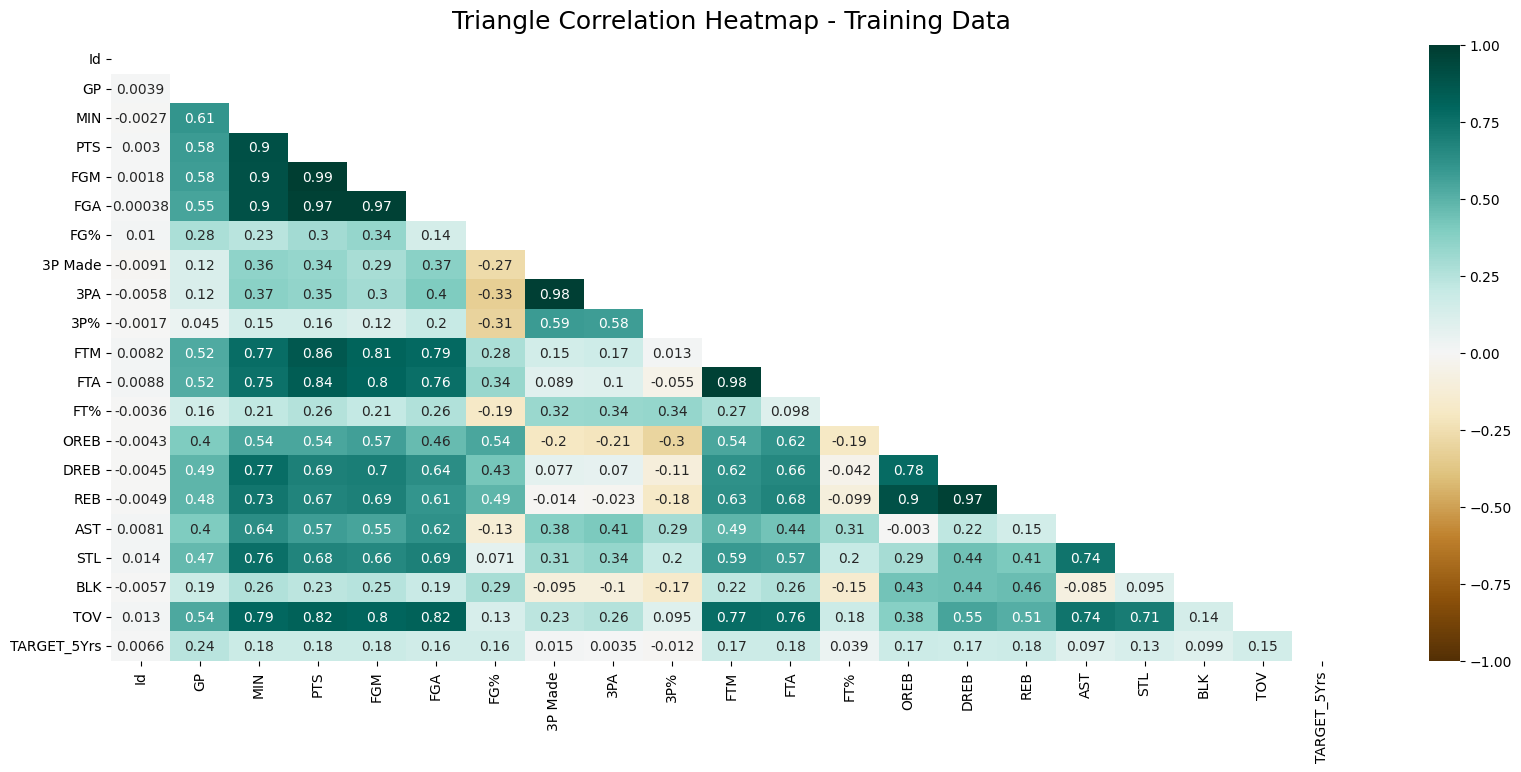

In [9]:
#Let's explore the correlation of the columns in the training set
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(trainingdata.corr(), dtype=np.bool))
heatmap = sns.heatmap(trainingdata.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Triangle Correlation Heatmap - Training Data', fontdict={'fontsize':18}, pad=12)

Text(0.5, 1.0, 'Triangle Correlation Heatmap - Test Data')

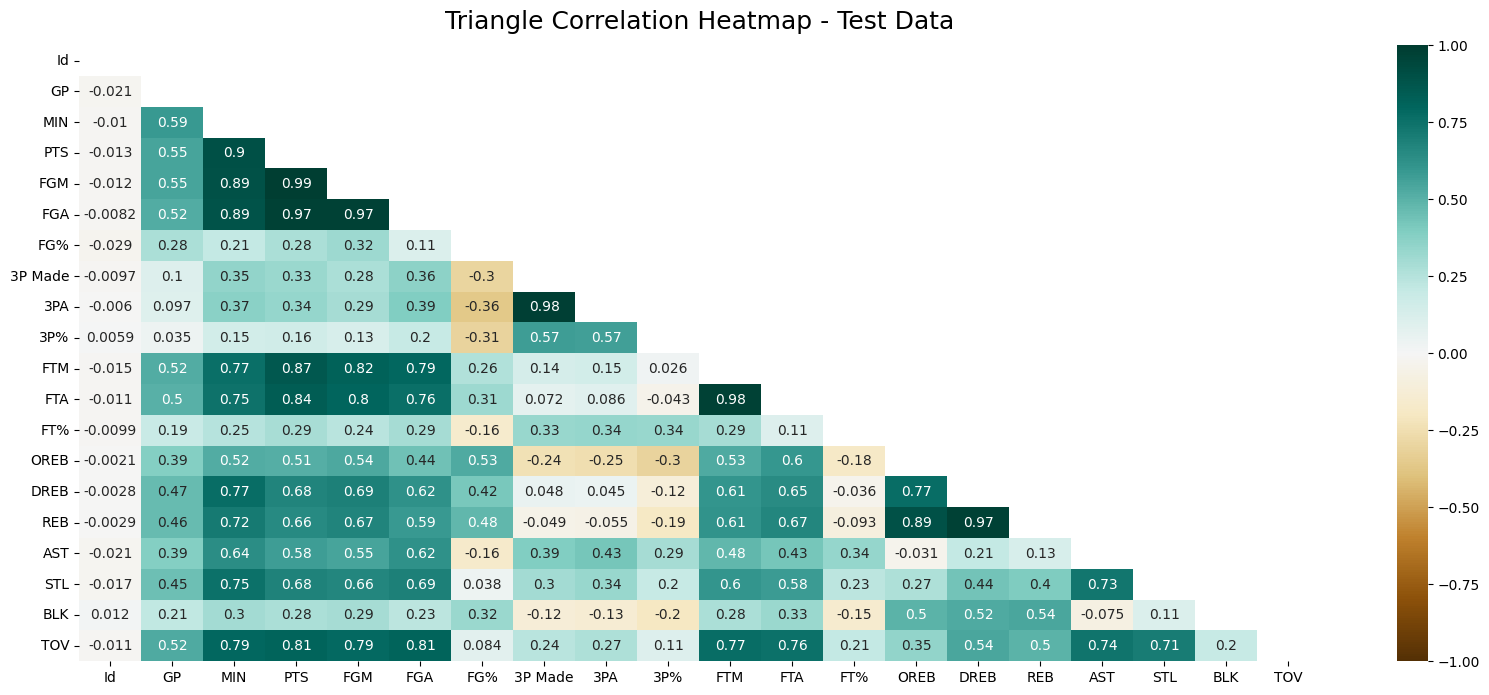

In [10]:
#Let's explore the correlation of the columns in the test set
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(testdata.corr(), dtype=np.bool))
heatmap = sns.heatmap(testdata.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Triangle Correlation Heatmap - Test Data', fontdict={'fontsize':18}, pad=12)

<h2> 3.1: Conclusion </h2>
<p>    a) Looking at the correlation heatmap, it looks like the correlation relationship between columns between the training data and test data is very similar <p>
<p>    b) Player ID should be used as the index as it is merely the identifier, and our target column is not correlated to this column <p>

In [11]:
#But first, let's copy the training data and test data
copy_trainingdata = trainingdata
copy_testdata = testdata


In [12]:
#Now we can set the column 'Id' as the index
copy_trainingdata.set_index(['Id'], inplace = True)
copy_testdata.set_index(['Id'], inplace = True)


In [13]:
copy_trainingdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,62.777875,18.576662,7.267088,2.807037,6.231212,44.608900,0.264525,0.816562,19.583700,1.392525,1.947788,71.365825,1.077838,2.168500,3.245300,1.624513,0.648687,0.245212,1.257763,0.833625
std,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,0.926153,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,0.700000,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.200000,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,1.900000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,8.100000,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [14]:
copy_testdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,8.500000,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


<h2> 3.2. Now we need to check if the test data is reasonably represented by the training data </h2>

In [15]:
#It is interesting to see that some of the training sets include negative values for Games Played (GP). It looks more like a typo that needs to be removed.
#The test data has a minimum GP of 6, let's remove anything in the training data with values less than 6

#It looks like we have the same happening with Free Throw %(FT%) and Block (BLK). Let's remove anything lower than 0 for these fields in the training data


In [16]:
clean_trainingdata = copy_trainingdata[(copy_trainingdata['GP']>=6) & (copy_trainingdata['FT%']>=0) & (copy_trainingdata['BLK']>=0)]

In [17]:
#Let's see what is unreasonably high and trim it from the dataset
clean_trainingdata 

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
Id,,,,,,,,,,,,,,,,,,,,
3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11793,65,22.2,6.9,2.8,6.9,40.5,0.5,1.5,36.6,0.8,1.1,62.6,0.2,1.0,1.1,2.8,0.6,0.1,1.3,0
11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1


In [18]:
#Let's check the initial size of the training data
print("This is the initial size of training data:") 
copy_trainingdata.shape


This is the initial size of training data:


(8000, 20)

In [19]:
#Let's check how many lines of data have we removed (I don't want to accidentally remove too much!)
print("And after removing outliers, we end up with this:") 
clean_trainingdata.shape

And after removing outliers, we end up with this:


(6948, 20)

In [20]:
#Let's see if the statistics of the clean training data is similar to the test data
#This is the training data
clean_trainingdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000,6948.000000
mean,64.148676,19.441321,7.634096,2.956952,6.494387,45.293912,0.250864,0.776569,18.509125,1.468739,2.067113,70.781002,1.183434,2.356203,3.536514,1.597539,0.665371,0.361399,1.302476,0.849021
std,16.768517,8.973393,4.371224,1.714179,3.631787,5.984451,0.381395,1.053998,15.701866,0.938635,1.264561,10.199483,0.782703,1.383351,2.066151,1.336376,0.412345,0.654506,0.730314,0.358054
min,6.000000,3.300000,0.800000,0.300000,0.900000,25.700000,-1.100000,-3.100000,-38.500000,0.000000,0.000000,13.500000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,53.000000,12.800000,4.400000,1.700000,3.800000,41.200000,0.000000,0.100000,7.700000,0.800000,1.100000,64.700000,0.600000,1.300000,2.000000,0.600000,0.400000,0.100000,0.800000,1.000000
50%,64.000000,17.700000,6.700000,2.600000,5.700000,45.100000,0.200000,0.800000,18.500000,1.300000,1.800000,70.900000,1.000000,2.100000,3.100000,1.200000,0.600000,0.300000,1.200000,1.000000
75%,75.000000,24.500000,9.900000,3.900000,8.400000,49.200000,0.500000,1.500000,29.300000,2.000000,2.700000,76.900000,1.600000,3.000000,4.600000,2.200000,0.900000,0.400000,1.700000,1.000000
max,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,73.700000,8.100000,11.100000,132.500000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


In [21]:
#This is the test data
testdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,8.500000,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


<h3> 3.2.1 It looks like I have shaved too much of the low-performing players from the training data. </h3>
<p> If we look at the target column 'TARGET_5Yrs', the training data is heavily skewed towards 1, with mean = 0.849
<p> Hm... I will try to undersample data with target column 'TARGET_5Yrs' values = 1


In [22]:
Success = pd.DataFrame(clean_trainingdata[clean_trainingdata['TARGET_5Yrs']==1])
Fail = pd.DataFrame(clean_trainingdata[clean_trainingdata['TARGET_5Yrs']==0])
print ("Instances of Target pass 5 Yrs: " + str(Success.shape[0]))
print ("Instances of Target doesn't pass 5 Yrs: " + str(Fail.shape[0]))

Instances of Target pass 5 Yrs: 5899
Instances of Target doesn't pass 5 Yrs: 1049


In [23]:
resampled_Success = resample(Success, replace =True, n_samples=4000, random_state=123)
resampled_Success.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0
mean,66.091750,20.11110,7.913625,3.067275,6.700900,45.575125,0.256300,0.78695,18.697850,1.531250,2.14345,71.142900,1.235275,2.465900,3.695725,1.650075,0.691900,0.386750,1.340275,1.0
std,16.801366,9.02819,4.440963,1.745320,3.699568,5.855095,0.378631,1.04602,15.781995,0.952977,1.27172,10.490529,0.811362,1.415506,2.120706,1.339669,0.411755,0.685705,0.736927,0.0
min,11.000000,3.30000,0.900000,0.400000,1.000000,27.500000,-0.900000,-2.40000,-31.000000,0.000000,0.00000,13.500000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.100000,1.0
25%,55.000000,13.30000,4.600000,1.800000,4.000000,41.600000,0.000000,0.10000,7.900000,0.800000,1.20000,64.800000,0.600000,1.400000,2.100000,0.700000,0.400000,0.200000,0.800000,1.0
50%,66.000000,18.50000,7.000000,2.700000,5.900000,45.300000,0.300000,0.80000,18.600000,1.400000,1.90000,70.900000,1.100000,2.200000,3.200000,1.300000,0.600000,0.300000,1.200000,1.0
75%,77.000000,25.30000,10.200000,4.000000,8.600000,49.200000,0.500000,1.50000,29.625000,2.100000,2.80000,77.300000,1.600000,3.200000,4.800000,2.300000,0.900000,0.400000,1.700000,1.0
max,123.000000,66.30000,30.800000,12.000000,28.900000,67.200000,1.600000,4.40000,72.300000,7.600000,9.60000,117.500000,5.400000,11.000000,15.900000,12.800000,3.600000,15.100000,5.200000,1.0


In [24]:
new_trainingdata = pd.concat([resampled_Success, Fail])
new_trainingdata.shape

(5049, 20)

In [25]:
new_trainingdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000,5049.000000
mean,63.848089,19.246801,7.500337,2.902832,6.395861,45.089285,0.252387,0.783323,18.598614,1.446247,2.030541,70.798772,1.166092,2.342305,3.504437,1.574807,0.663319,0.363636,1.283700,0.792236
std,17.117130,8.853578,4.334446,1.699969,3.602285,5.940830,0.378517,1.046060,15.763150,0.935286,1.247529,10.394827,0.785899,1.378810,2.064508,1.302843,0.403768,0.646906,0.720576,0.405747
min,10.000000,3.300000,0.800000,0.300000,0.900000,25.700000,-1.100000,-3.100000,-33.400000,0.000000,0.000000,13.500000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,52.000000,12.700000,4.300000,1.600000,3.700000,41.000000,0.000000,0.100000,8.000000,0.800000,1.100000,64.500000,0.600000,1.300000,2.000000,0.600000,0.400000,0.100000,0.800000,1.000000
50%,64.000000,17.600000,6.600000,2.500000,5.600000,44.900000,0.200000,0.800000,18.600000,1.200000,1.800000,70.700000,1.000000,2.000000,3.000000,1.200000,0.600000,0.300000,1.100000,1.000000
75%,75.000000,24.200000,9.700000,3.800000,8.300000,48.900000,0.500000,1.500000,29.400000,1.900000,2.700000,77.000000,1.500000,3.000000,4.600000,2.200000,0.900000,0.400000,1.700000,1.000000
max,123.000000,66.300000,30.800000,12.000000,28.900000,67.200000,1.600000,4.600000,73.700000,7.600000,9.600000,124.900000,5.400000,11.000000,15.900000,12.800000,3.600000,15.100000,5.200000,1.000000


In [26]:
#This is the test data
testdata.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000,3799.000000
mean,62.853909,18.650224,7.328034,2.835404,6.302580,44.599079,0.255962,0.796920,19.234746,1.399842,1.953567,71.612924,1.096025,2.179495,3.275783,1.636483,0.653593,0.257726,1.257910
std,17.151740,8.727259,4.294724,1.688427,3.579221,6.040168,0.380987,1.052862,15.968989,0.926140,1.250376,10.457336,0.785678,1.371935,2.070646,1.335496,0.410573,0.639660,0.712449
min,6.000000,3.700000,0.700000,0.300000,0.800000,25.100000,-1.000000,-2.700000,-38.000000,0.000000,0.000000,23.700000,0.000000,0.200000,0.300000,0.000000,0.000000,-7.100000,0.100000
25%,51.000000,12.200000,4.200000,1.600000,3.700000,40.500000,0.000000,0.100000,8.500000,0.700000,1.000000,65.000000,0.500000,1.200000,1.800000,0.600000,0.400000,0.100000,0.700000
50%,63.000000,17.000000,6.400000,2.500000,5.500000,44.600000,0.300000,0.800000,19.400000,1.200000,1.700000,71.500000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.300000,9.400000,3.700000,8.100000,48.500000,0.500000,1.500000,30.250000,1.900000,2.600000,78.000000,1.500000,2.900000,4.300000,2.300000,0.900000,0.400000,1.600000
max,126.000000,68.000000,33.000000,13.400000,26.200000,74.600000,1.600000,4.300000,73.800000,7.800000,9.800000,127.100000,6.900000,12.000000,18.500000,9.000000,2.700000,14.800000,5.200000


<h3> 3.2.2 Now it looks much better </h3>
<p> Let's look at the correlation heatmap with the cleaned & stratified training data

Text(0.5, 1.0, 'Triangle Correlation Heatmap - cleaned and stratified training data')

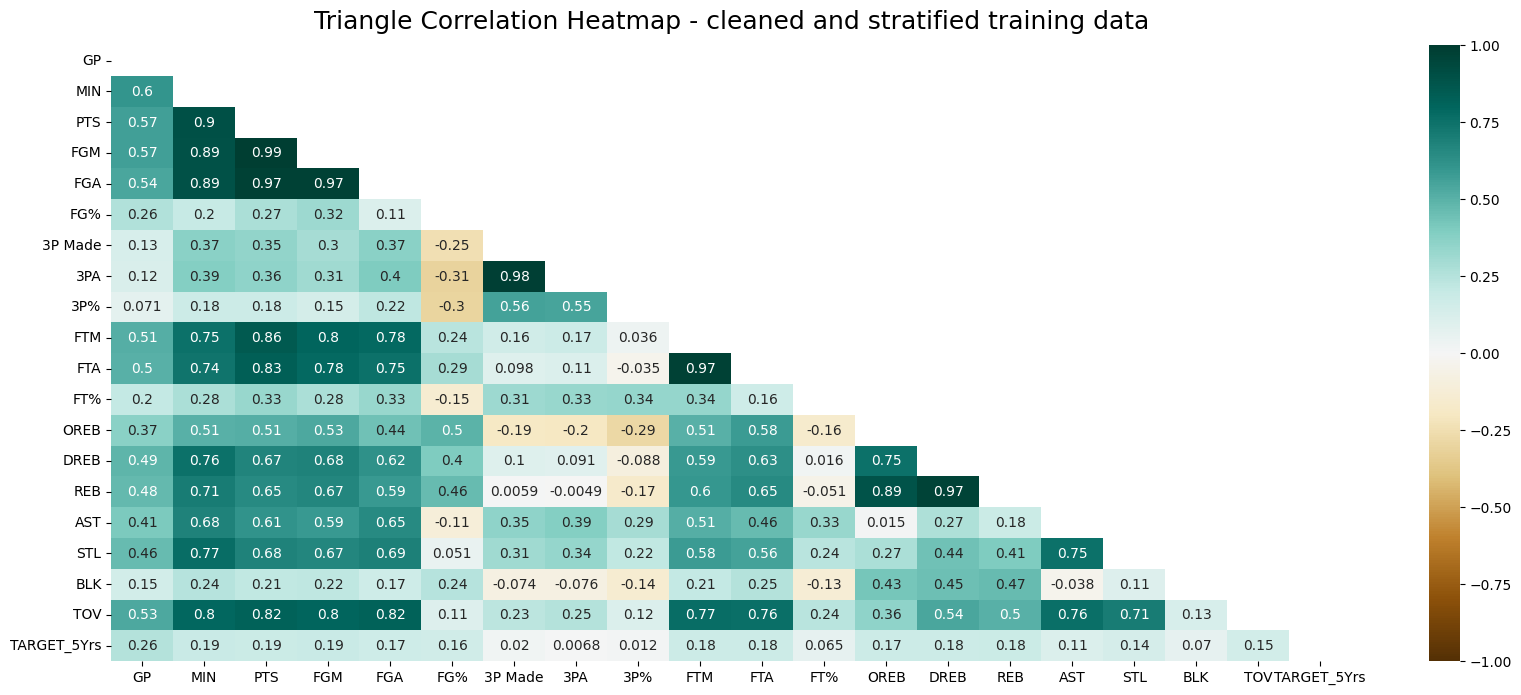

In [27]:
#Let's explore the correlation of the columns in the new training data
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(new_trainingdata.corr(), dtype=np.bool))
heatmap = sns.heatmap(new_trainingdata.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Triangle Correlation Heatmap - cleaned and stratified training data', fontdict={'fontsize':18}, pad=12)

<h1> 4. Feature Engineering <h1>

The training data is looking great, the statistics are looking more similar to the test data. Let's remove some highly correlated columns.
<p>There is a high correlation between MIN/PTS/FGM, so I will take just the MIN
<p>There is a high correlation between 3P Made and 3PA, so I will take just the 3P Made
<p>There is a high correlation between FTM and FTA, so I will take the FTM
<p>There is a high correlation between OREB/DREB/REB, so I will take the REB


In [28]:
    #Sklearn SVM
    #RandomForest
    #XGB


In [29]:
input_columns = ['GP', 
            'MIN', #'PTS', 'FGM', 
            'FG%',
            'FGA', 
            '3P Made', #'3PA', 
            '3P%',
            'FTM', #'FTA', 
            'FT%', 
            'REB', #'OREB', 'DREB',
            'AST', 'STL', 'BLK', 'TOV']

In [30]:
X = clean_trainingdata[input_columns]
y = clean_trainingdata['TARGET_5Yrs']

<h1> 5. Model Selection </h1>

<h4> 5.1 Random Forest Classifier with default setting and 300 forests</h4>
<p> Kaggle score 0.68522

In [31]:
#Let's train the Random Forest Classifier with 300 forests
classifier = RandomForestClassifier(random_state=0, n_estimators=300)
classifier.fit(X, y) 

RandomForestClassifier(n_estimators=300, random_state=0)

In [32]:
#Let's apply the classifier to the test data
X_test=testdata[input_columns]
y_hat = classifier.predict_proba(X_test)
y_hat_df = pd.DataFrame(y_hat)


In [33]:
y_hat_df

,0,1
0,0.346667,0.653333
1,0.280000,0.720000
2,0.030000,0.970000
3,0.073333,0.926667
4,0.283333,0.716667
...,...,...
3794,0.010000,0.990000
3795,0.216667,0.783333
3796,0.206667,0.793333
3797,0.053333,0.946667


In [34]:
submission = y_hat_df[1].round(2)
submission


0       0.65
1       0.72
2       0.97
3       0.93
4       0.72
        ... 
3794    0.99
3795    0.78
3796    0.79
3797    0.95
3798    0.85
Name: 1, Length: 3799, dtype: float64

In [35]:
submission.to_csv("submission.csv")

['model.joblib']

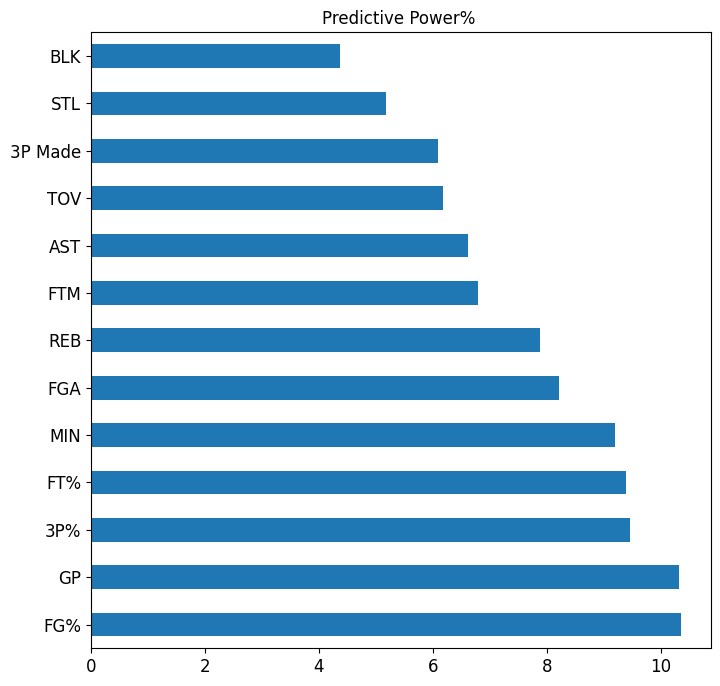

In [36]:
feature_imp = pd.Series(np.round(100 * classifier.feature_importances_,2), index = X.columns)
plt.figure(figsize=(8,8))
feature_imp.nlargest(30).plot(kind='barh', title='Predictive Power% ',fontsize=12)                        
plt.savefig('features.png', bbox_inches='tight')
joblibpath = 'model.joblib'
joblib.dump(classifier, joblibpath, compress=3)

<h4> 5.2 Let's now try XGBoost with default setting </h4>
<p> Kaggle score 0.63475

In [37]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [38]:
classifier_2 = XGBClassifier(n_estimators = 300)
classifier_2.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [39]:
X_test=testdata[input_columns]
y_hat_XGB = classifier_2.predict_proba(X_test)
y_hat_XGB_df = pd.DataFrame(y_hat_XGB)

In [40]:
y_hat_XGB_df

,0,1
0,0.246947,0.753053
1,0.126827,0.873173
2,0.001781,0.998219
3,0.000531,0.999469
4,0.092273,0.907727
...,...,...
3794,0.006396,0.993604
3795,0.068054,0.931946
3796,0.008183,0.991817
3797,0.095320,0.904680


In [41]:
submission_XGB = y_hat_XGB_df[1].round(2)
submission_XGB

0       0.75
1       0.87
2       1.00
3       1.00
4       0.91
        ... 
3794    0.99
3795    0.93
3796    0.99
3797    0.90
3798    0.94
Name: 1, Length: 3799, dtype: float32

In [42]:
submission_XGB.to_csv("submissionXGB.csv")